# Step 1: Data Collection, Processing, and Visualization

## 1.1. Collecting YEN Data:

In [1]:
import yfinance as yf
# Downloading JPY/USD data
jpy_usd = yf.download('JPY=X', start='2021-03-10', end='2024-08-30', interval='1d')

# Display the first few rows
print(jpy_usd.head())

# Save to CSV
jpy_usd.to_csv('JPY_USD_data.csv')

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2021-03-10  108.564003  108.919998  108.338997  108.577003  108.577003       0
2021-03-11  108.435997  108.802002  108.362999  108.431999  108.431999       0
2021-03-12  108.573997  109.148003  108.518997  108.555000  108.555000       0
2021-03-15  109.113998  109.356003  108.931000  109.116997  109.116997       0
2021-03-16  109.119003  109.276001  108.782997  109.134003  109.134003       0


## 1.2. Collecting GYEN Data:

In [2]:
import yfinance as yf

# Download GYEN/USD data
gyen_usd = yf.download('GYEN-USD', start='2021-03-10', end='2024-08-30', interval='1d')

# Display the first few rows
print(gyen_usd.head())

# Save to CSV
gyen_usd.to_csv('GYEN_USD_data.csv')

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2021-03-10  0.009226  0.009231  0.009224  0.009229   0.009229   38233
2021-03-11  0.009228  0.009232  0.009191  0.009212   0.009212  308571
2021-03-12  0.009210  0.009215  0.009155  0.009179   0.009179   37345
2021-03-13  0.009179  0.009187  0.009165  0.009178   0.009178  201012
2021-03-14  0.009178  0.009189  0.009168  0.009168   0.009168   49557


## 1.3. Handling Missing Data

In [3]:
# Check for missing values
print('Missing values in JPY data:\n', jpy_usd.isna().sum())
print('Missing values in GYEN data:\n', gyen_usd.isna().sum())

# Handling Missing Data with Updated Methods
jpy_usd.ffill(inplace=True)  # Forward fill missing values
gyen_usd.ffill(inplace=True)  # Forward fill missing values

Missing values in JPY data:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Missing values in GYEN data:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


## 1.4. Data Normalization

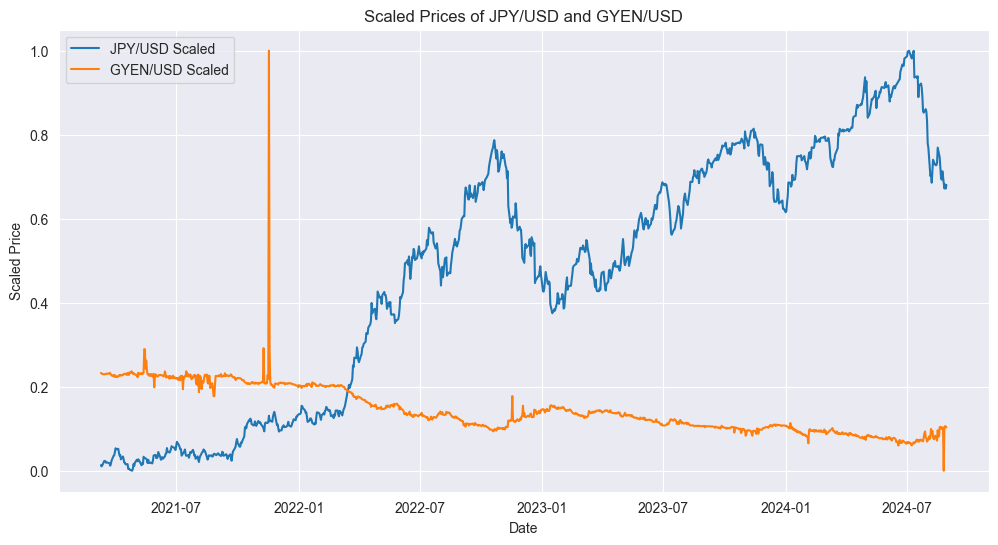

In [4]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Initialize the scaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling
jpy_usd['Close_scaled'] = scaler.fit_transform(jpy_usd[['Close']])
gyen_usd['Close_scaled'] = scaler.fit_transform(gyen_usd[['Close']])

# Plot scaled data
plt.figure(figsize=(12, 6))
plt.plot(jpy_usd.index, jpy_usd['Close_scaled'], label='JPY/USD Scaled')
plt.plot(gyen_usd.index, gyen_usd['Close_scaled'], label='GYEN/USD Scaled')
plt.title('Scaled Prices of JPY/USD and GYEN/USD')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

## 1.5. Stationarity Check with ADF Test

In [5]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test
adf_result_jpy = adfuller(jpy_usd['Close_scaled'].dropna())
adf_result_gyen = adfuller(gyen_usd['Close_scaled'].dropna())

print(f'JPY ADF Statistic: {adf_result_jpy[0]}, p-value: {adf_result_jpy[1]}')
print(f'GYEN ADF Statistic: {adf_result_gyen[0]}, p-value: {adf_result_gyen[1]}')

JPY ADF Statistic: -1.3929795397559643, p-value: 0.5856371491628167
GYEN ADF Statistic: -1.468632826797084, p-value: 0.548967260559881


Findings:

Both the JPY and GYEN ADF statistics are not very negative (only around -1.38 and -1.47, respectively), and the p-values are high (0.59 for JPY and 0.55 for GYEN). These results indicate that the null hypothesis cannot be rejected, meaning both time series are likely non-stationary.

Given that both JPY and GYEN series are non-stationary, we will likely need to difference the data to achieve stationarity before applying the ARIMA model.

So, we run the following processes:

In [6]:
# Applying first differencing
jpy_usd['Close_diff'] = jpy_usd['Close'].diff().dropna()
gyen_usd['Close_diff'] = gyen_usd['Close'].diff().dropna()

# Re-running the ADF test
from statsmodels.tsa.stattools import adfuller

adf_result_jpy_diff = adfuller(jpy_usd['Close_diff'].dropna())
adf_result_gyen_diff = adfuller(gyen_usd['Close_diff'].dropna())

print(f'JPY Differenced ADF Statistic: {adf_result_jpy_diff[0]}, p-value: {adf_result_jpy_diff[1]}')
print(f'GYEN Differenced ADF Statistic: {adf_result_gyen_diff[0]}, p-value: {adf_result_gyen_diff[1]}')

JPY Differenced ADF Statistic: -29.613979749768923, p-value: 0.0
GYEN Differenced ADF Statistic: -13.514711724261565, p-value: 2.808952507565943e-25


Findings:

Significantly Negative ADF Statistics: Both ADF statistics are highly negative (-29.62 for JPY and -13.51 for GYEN), indicating strong evidence against the null hypothesis of non-stationarity. The more negative the ADF statistic, the stronger the rejection of the null hypothesis.

Very Low p-values: Both p-values are extremely low (0.0 for JPY and approximately 0.0 for GYEN), which are far below the typical threshold of 0.05. This means there is a very strong rejection of the null hypothesis that the series are non-stationary.

The differenced time series for both JPY and GYEN are now stationary. This means you have successfully transformed the original non-stationary data into a stationary form, which is suitable for ARIMA modeling.

## 1.6. Rolling Volatility Plot

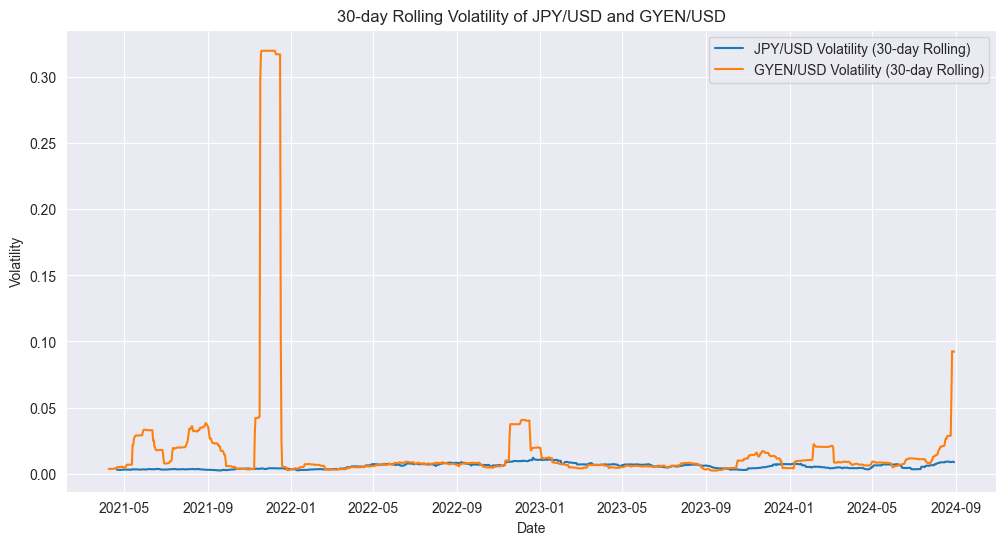

In [7]:
# Calculate rolling volatility (30-day rolling window)
jpy_usd['Rolling_Volatility'] = jpy_usd['Close'].pct_change().rolling(window=30).std()
gyen_usd['Rolling_Volatility'] = gyen_usd['Close'].pct_change().rolling(window=30).std()

# Plot rolling volatility
plt.figure(figsize=(12, 6))
plt.plot(jpy_usd.index, jpy_usd['Rolling_Volatility'], label='JPY/USD Volatility (30-day Rolling)')
plt.plot(gyen_usd.index, gyen_usd['Rolling_Volatility'], label='GYEN/USD Volatility (30-day Rolling)')
plt.title('30-day Rolling Volatility of JPY/USD and GYEN/USD')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Step 2: Modeling

## 2.1. ARIMA Modeling (GYEN Data Only)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1269
Model:                 ARIMA(1, 1, 1)   Log Likelihood                7951.634
Date:                Fri, 06 Sep 2024   AIC                         -15897.268
Time:                        17:20:50   BIC                         -15881.833
Sample:                    03-10-2021   HQIC                        -15891.470
                         - 08-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0822      0.007     11.881      0.000       0.069       0.096
ma.L1         -0.7282      0.007   -106.474      0.000      -0.742      -0.715
sigma2      2.051e-07    4.1e-10    499.870      0.0

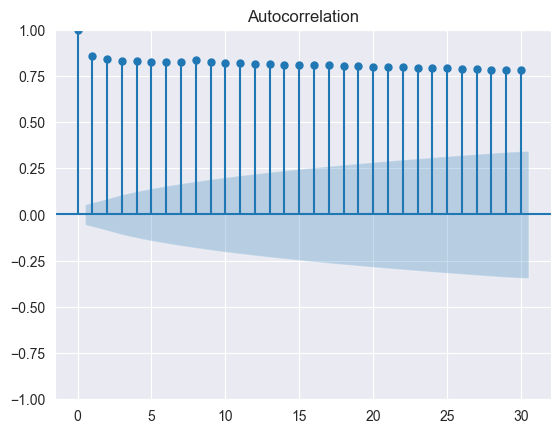

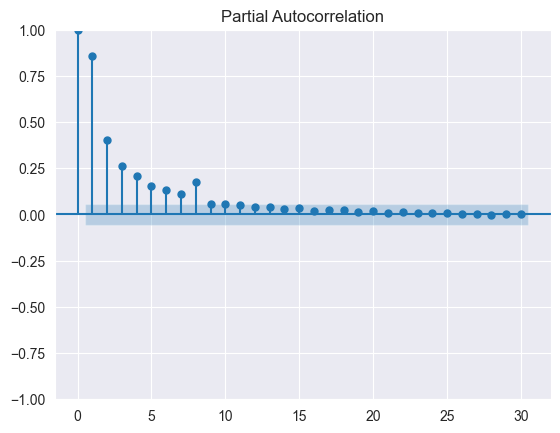

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(gyen_usd['Close'].dropna(), lags=30)
plot_pacf(gyen_usd['Close'].dropna(), lags=30)

from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(gyen_usd['Close'].dropna(), order=(1, 1, 1))
arima_fit = arima_model.fit()

# Summary of the ARIMA model
print(arima_fit.summary())